# Plan:

### Phase 2 will utilize the subset of women that were identified as abused in the study and compound extra features that were gleaned in a follow-up survey of these identified women.  These features will be narrowed and modeled to identify risk of being reassaulted.  This work will investigate appropriately on a compounded dataframe of our original features in addition to the new features from the follow-up survey.

### Hypothesis: From domain knowledge of this field, we predict that there will likely be significant identifiers of abuse that can be fed into a machine-learned model.  Typically, choking is identified as a primary risk identifier so we expect to see this, among other physical acts as good identifiers.  Phase 1 gave us insight that measures of power and control correlate toward risk of first assault, so we expect this to play a factor as well.

# ENVIRONMENT

In [53]:
# basic environment and custom scripts
import warnings
warnings.filterwarnings("ignore")

import os
import time

# import pipeline scripts
import acquire
import prepare
import explore
import model

# numpy and pandas for dataframe building and manipulation
import pandas as pd
import numpy as np


# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# import preprocessing for scaling and splitting
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# xgboost for potential feature selection
import xgboost as xgb

# sklearn machine learning
from sklearn.linear_model import SGDClassifier

# classification reports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Dimensionality
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#  balanced bagging classifier
from imblearn.ensemble import BalancedBaggingClassifier

# to explode the DataFrames and avoid truncation
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# ACQUISITION

In [54]:
# utilize acquire script to get primary dataframe for analysis
dfa, dfb = acquire.get_data()

# PREPARATION

## We will push forward and prepare dfa as we did in Phase 1.  Details and checks may be examined in the Phase 1 notebook

In [55]:
# create recidivism column
dfa['RECID'] = dfa.CASEID.apply(prepare.get_repeat_case)
# use prepare function to rename features 
dfa = prepare.rename_columns_all(dfa)
# use prepare function to re-encode data
prepare.replace_nonvals_all(dfa)

In [56]:
#peek at dfb
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


In [57]:
# formally check that there are no nulls in dataframe b
prepare.get_nulls_by_column(dfb)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [58]:
# check no 2
if not prepare.get_nulls_by_row(dfb):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(dfb)

no nulls!


In [59]:
prepare.summarize_data(dfb)

HEAD
   CASEID  M5FIRED  M11HIGH  M35SAFE  M41ILLGL  M42DAGRR  M13TALKR  M32OTHER  \
0  108395     9999        2        1         2         0         1        99   
1  108397     9999        2        1         2         0         1        99   
2  108399     9999        2        1         2         0         1        99   
3  108443     9999        2        1         2         0         1        13   
4  108444     9999        1        1         2         0         1        99   

   M27HOW  M30ARRES    ...     FORCEDR  MISCARR  RESTRAIN  CHOKED  NDRUNK  \
0   99999         3    ...           0        0         0       0       0   
1   99999         3    ...           0        0         0       1       2   
2   99999         3    ...           0        0         1       1       0   
3   99999         3    ...           0        0         0       1       1   
4   99999         3    ...           0        0         0       0       3   

   RDRUNK  BOTHDRUN  NDRUGS  RDRUGS  BOTHDRUG  
0  

## We can see the cases where reassault happened. There are 350 cases out of the original 705 (before the padding implemented in Phase 1). There were 497 cases of domestic violence (cases where the surveyed was identified as abused).

In [60]:
# make new dataframe out of subset of dfa where we only look at the victims of abuse
dfa_abused = dfa[dfa.abuse_past_year == 1]

In [61]:
# cursory glance at dfb
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 29 columns):
CASEID      497 non-null int64
M5FIRED     497 non-null int64
M11HIGH     497 non-null int64
M35SAFE     497 non-null int64
M41ILLGL    497 non-null int64
M42DAGRR    497 non-null int64
M13TALKR    497 non-null int64
M32OTHER    497 non-null int64
M27HOW      497 non-null int64
M30ARRES    497 non-null int64
M31HOW      497 non-null int64
M38ORDER    497 non-null int64
SEVERER     497 non-null int64
TOTINCR     497 non-null int64
THREATR     497 non-null int64
SLAPR       497 non-null int64
PUNCHR      497 non-null int64
BEATR       497 non-null int64
UWEAPON     497 non-null int64
FORCEDR     497 non-null int64
MISCARR     497 non-null int64
RESTRAIN    497 non-null int64
CHOKED      497 non-null int64
NDRUNK      497 non-null int64
RDRUNK      497 non-null int64
BOTHDRUN    497 non-null int64
NDRUGS      497 non-null int64
RDRUGS      497 non-null int64
BOTHDRUG    497 non-null in

In [62]:
# re-name columns in dfb into more readable features
dfb = prepare.rename_columns_recid(dfb)

In [63]:
# re-encode / clean values from dfb dataframe
prepare.replace_nonvals_recid(dfb)

In [66]:
# merge our dfb data onto our original phase one data set
df = dfa_abused.merge(right=dfb, on='id')

In [67]:
prepare.summarize_data(df)

HEAD
       id  abuse_past_year  abuse_status  length_relationship  \
0  108395                1             1                    1   
1  108397                1             1                    2   
2  108399                1             1                    5   
3  108443                1             1                    2   
4  108444                1             1                    2   

   partner_abusive  num_abusers  num_children  pregnant  \
0                1            1             1         0   
1                1            1             0         0   
2                1            1             2         0   
3                1            1             0         1   
4                1            1             1         0   

   beaten_while_pregnant  support_score       ...        num_forced_sex  \
0                      0              0       ...                     0   
1                      0             11       ...                     0   
2                      0

Name: num_incidents, dtype: int64

-------------------------------------------------------------

num_threats
0    392
1     45
2     19
3     19
4     22
Name: num_threats, dtype: int64

-------------------------------------------------------------

num_slapping
0    219
1    123
2     79
3     40
4     36
Name: num_slapping, dtype: int64

-------------------------------------------------------------

num_punching
0    259
1    116
2     74
3     28
4     20
Name: num_punching, dtype: int64

-------------------------------------------------------------

num_beating
0    320
1    116
2     45
3     11
4      5
Name: num_beating, dtype: int64

-------------------------------------------------------------

num_weapon
0    436
1     49
2      9
3      2
8      1
Name: num_weapon, dtype: int64

-------------------------------------------------------------

num_forced_sex
0    378
1     57
2     25
3     17
4     20
Name: num_forced_sex, dtype: int64

---------------------------------------

In [68]:
df.reassault.value_counts()

1    350
0    147
Name: reassault, dtype: int64

### We will balance out our dataset for modeling by doubling the number of single-abuse cases.  This will reduce bias of accuracy when we create our models.

In [69]:
# isolate single abuse cases into 
single_abuse = df[df.reassault == 0]

In [70]:
# create new dataframe of just single abuse cases, reassign them new range of case ids
single_abuse['id'] = range(999999, 999999 + len(single_abuse))

In [71]:
#append the padded single assault values to our greater dataframe
df = df.append(single_abuse)

In [72]:
# formally check that there are no nulls in dataframe
prepare.get_nulls_by_column(df)

Empty DataFrame
Columns: [sum_nulls, nulls_by_percent]
Index: []


In [73]:
# check no 2
if not prepare.get_nulls_by_row(df):
    print('no nulls!')
else:
    prepare.get_nulls_by_row(df)

no nulls!


In [74]:
df.shape

(644, 73)

In [75]:
df.reassault.value_counts()

1    350
0    294
Name: reassault, dtype: int64

In [76]:
# create list of features
features = [col for col in df]
# drop features from this list that are perceived as primary key or target variable
features.remove('id')
features.remove('abuse_past_year')
features.remove('abuse_status')
features.remove('reassault')

In [77]:
features

['length_relationship',
 'partner_abusive',
 'num_abusers',
 'num_children',
 'pregnant',
 'beaten_while_pregnant',
 'support_score',
 'guns_in_home',
 'jealous_past_year',
 'limit_family_contact',
 'location_tracking',
 'threat_hit',
 'threat_object',
 'push_shove',
 'slap',
 'kick_punch',
 'hit_object',
 'beaten',
 'choked',
 'threat_knife',
 'threat_gun',
 'rape_with_threat',
 'power_scale',
 'harass_scale',
 'id_age',
 'age_disparity',
 'children_not_partner',
 'same_sex_relationship',
 'partner_drug_use',
 'partner_alcohol_use',
 'threat_suicide',
 'partner_reported_child_abuse',
 'partner_arrested',
 'violence_increased',
 'severity_increased',
 'weapon_ever',
 'choked_ever',
 'rape_ever',
 'controlled_ever',
 'jealous',
 'capable_murder',
 'gun_fired',
 'anyone_high',
 'safe_place',
 'forced_illegal',
 'life_danger',
 'talk_about_it',
 'left_or_not',
 'medical_staff_helpful',
 'perp_arrested_ever',
 'police_resp',
 'order_protection',
 'level_severity',
 'num_incidents',
 'num_t

In [23]:
df.to_csv('phase2_df.csv')

In [24]:
# split train and test
X = df[features]
y = df[['reassault']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# EXPLORATION

## We will run chi-squared tests on our categorical variables in order to get a grasp of importance

In [25]:
# we will run chi-squared tests on our categorical variables in order to get a grasp of importance
sig_feats, sig_dict = explore.get_chi_squared(train_df, features, 'reassault')

length_relationship
Dependent (reject H0)
-----------------------
num_abusers
Dependent (reject H0)
-----------------------
beaten_while_pregnant
Dependent (reject H0)
-----------------------
support_score
Dependent (reject H0)
-----------------------
jealous_past_year
Dependent (reject H0)
-----------------------
limit_family_contact
Dependent (reject H0)
-----------------------
location_tracking
Dependent (reject H0)
-----------------------
threat_hit
Dependent (reject H0)
-----------------------
threat_object
Dependent (reject H0)
-----------------------
push_shove
Dependent (reject H0)
-----------------------
slap
Dependent (reject H0)
-----------------------
kick_punch
Dependent (reject H0)
-----------------------
hit_object
Dependent (reject H0)
-----------------------
beaten
Dependent (reject H0)
-----------------------
choked
Dependent (reject H0)
-----------------------
threat_knife
Dependent (reject H0)
-----------------------
threat_gun
Dependent (reject H0)
----------------

In our case, essentially every feature is represented as a categorical bin (The scale features are compounded aggregates of other questions in the survey).  This leaves age as our only perceivably continuous feature.  We will scale it and test it to see if it has any significance as well.

In [78]:
# scale continuous variables
scaler = MinMaxScaler()

scaler.fit(train_df[['id_age']])

train_df[['id_age']] = scaler.transform(train_df[['id_age']])
test_df[['id_age']] = scaler.transform(test_df[['id_age']])

In [79]:
continuous_vars = ['id_age']

In [80]:
sig_feats_c, sig_dict_c = explore.get_significant_t_tests(train_df, ['id_age'], 'reassault')

In [81]:
# call function that combines significant features from dictionaries created in statistical tests if both generated results
# otherwise make list of features just from whichever (t test or chi squared) produced significant results
if sig_feats_c and sig_feats:
    features = explore.combine_significants(sig_dict, sig_dict_c)
elif sig_feats_c:
    features = [item[0] for item in explore.sort_sigs(sig_dict_c)]
elif sig_feats:
    features = [item[0] for item in explore.sort_sigs(sig_dict)]

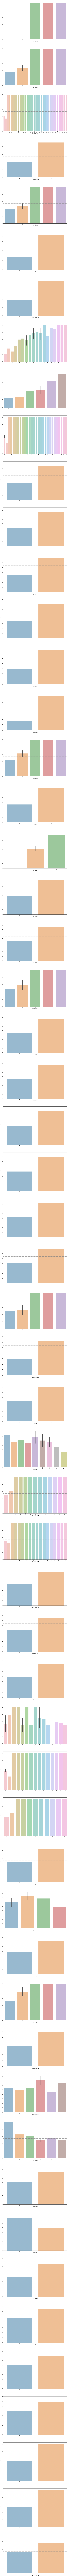

In [82]:
explore.make_bars(train_df, 'reassault', features)

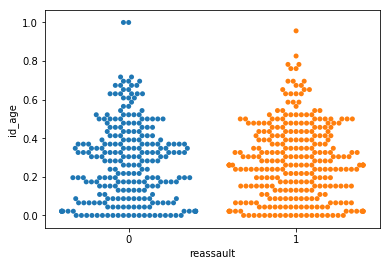

In [86]:
sns.swarmplot(data = train_df, x='reassault', y='id_age')

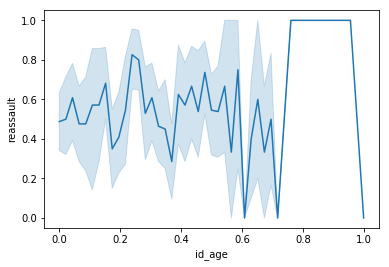

In [87]:
for feature in continuous_vars:
   sns.lineplot(x=feature, y='reassault', data=train_df)
   plt.show()

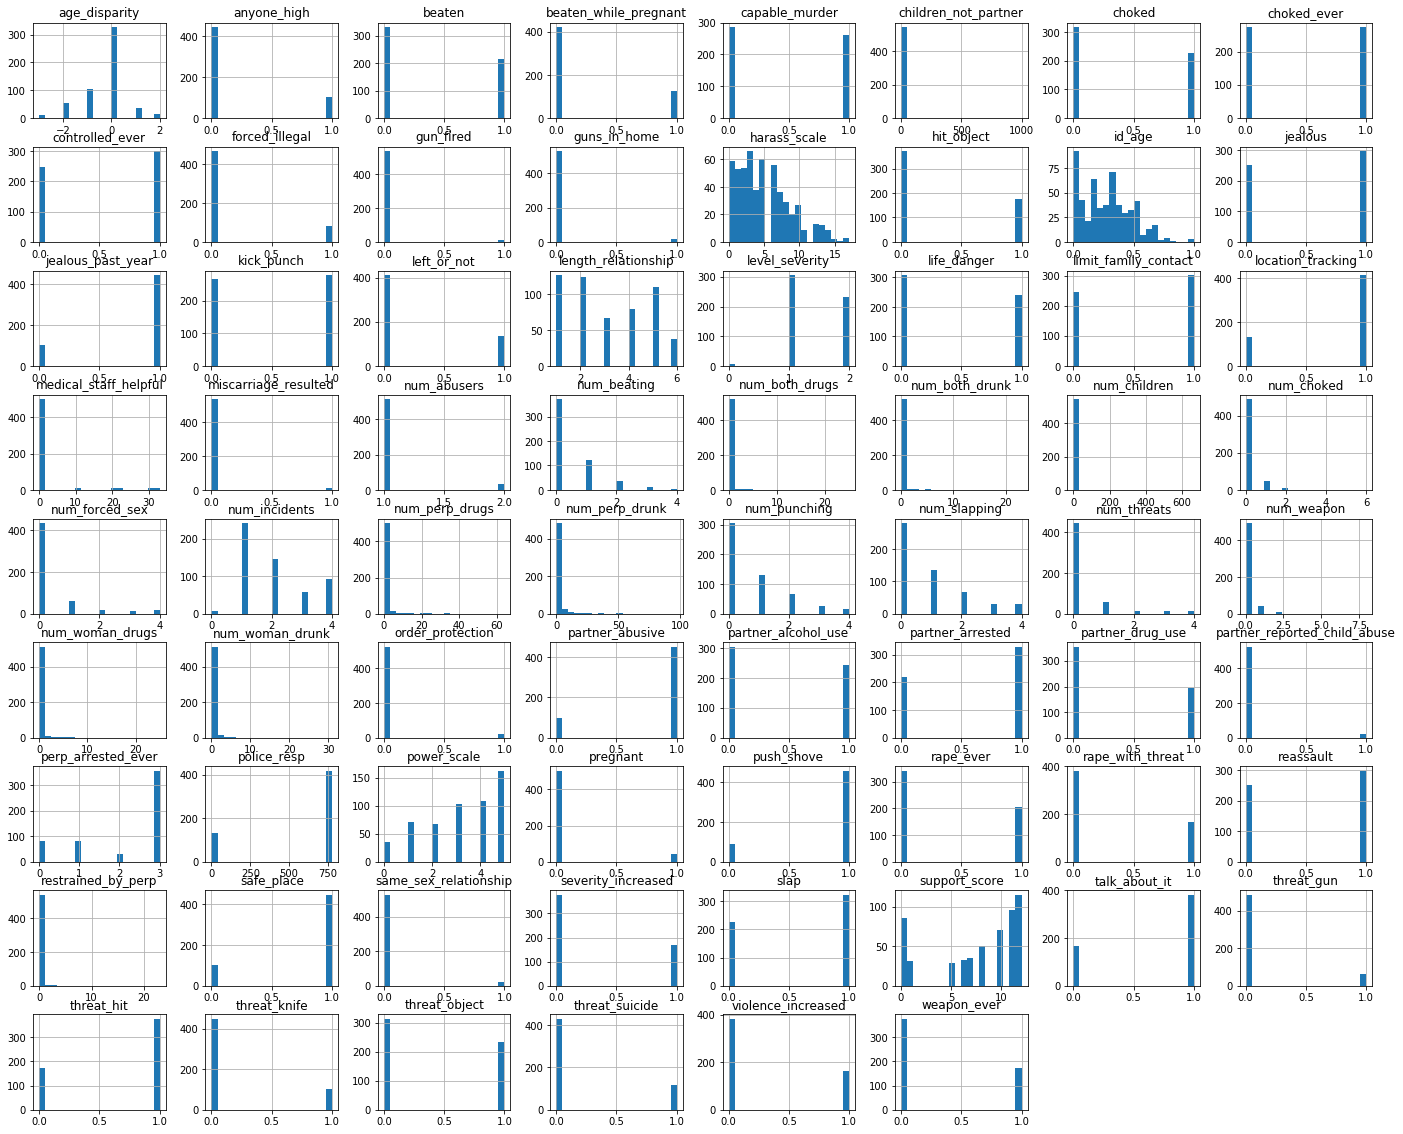

In [88]:
# histograms
# normalization(?)
explore.plot_hist(train_df)

In [35]:
# function to remove any "significant features" that automatically denote target
prepare.remove_phase_2_features(features)

### The goal of our end product is to have a simple and minimally invasive survey.  The harassment and power scale require several questions compounded into one feature.  They are significant but not to the point of efficacy that our model would significantly break without them for the sake of user ease.

In [91]:
# Remove aggregate features
features.remove('harass_scale')
features.remove('power_scale')
features.remove('level_severity')

ValueError: list.remove(x): x not in list

# Modeling:

### We will attempt several different tactics and models as a means to find the best fit for our data set.  We will try with various features and par down with what we found as being statistically significant through chi-squared testing.

# Naive Bayes

#### Naive Bayes will give us a good baseline standard for model efficacy.  We will establish our model testing method here and continue forward with it, wherein we create a model feature by feature by compounding each additional feature from our ranked feature importance list iteratively through a loop.  Each of these models will be cross-validated to check for overfitting before we select a model to implement.

In [93]:
# create list of lists that increase number of features in list
that_list = []
list_of_feature_lists = []
for i in range(1,43):
    that_list = features[0:i]
    list_of_feature_lists.append(that_list)

In [94]:
# loop to identify efficacy of models
for list_item in list_of_feature_lists:
    gnb, y_pred, y_pred_proba = model.naive_bayes(list_item, X_train, y_train)
    print('--------------------------------------------------------')
    print(f'Model based on top {len(list_item)} features')
    print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train[list_item], y_train)))
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    print('--------------------------------------------------------')

--------------------------------------------------------
Model based on top 1 features
Accuracy of GNB classifier on training set: 0.99
[[242   8]
 [  0 297]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       250
           1       0.97      1.00      0.99       297

   micro avg       0.99      0.99      0.99       547
   macro avg       0.99      0.98      0.99       547
weighted avg       0.99      0.99      0.99       547

--------------------------------------------------------
--------------------------------------------------------
Model based on top 2 features
Accuracy of GNB classifier on training set: 0.99
[[242   8]
 [  0 297]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       250
           1       0.97      1.00      0.99       297

   micro avg       0.99      0.99      0.99       547
   macro avg       0.99      0.98      0.99       547
weighted avg       0.99   

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       250
           1       0.97      0.97      0.97       297

   micro avg       0.97      0.97      0.97       547
   macro avg       0.97      0.97      0.97       547
weighted avg       0.97      0.97      0.97       547

--------------------------------------------------------
--------------------------------------------------------
Model based on top 19 features
Accuracy of GNB classifier on training set: 0.95
[[237  13]
 [ 12 285]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       250
           1       0.96      0.96      0.96       297

   micro avg       0.95      0.95      0.95       547
   macro avg       0.95      0.95      0.95       547
weighted avg       0.95      0.95      0.95       547

--------------------------------------------------------
--------------------------------------------------------
Model based on 

Accuracy of GNB classifier on training set: 0.91
[[230  20]
 [ 31 266]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       250
           1       0.93      0.90      0.91       297

   micro avg       0.91      0.91      0.91       547
   macro avg       0.91      0.91      0.91       547
weighted avg       0.91      0.91      0.91       547

--------------------------------------------------------
--------------------------------------------------------
Model based on top 36 features
Accuracy of GNB classifier on training set: 0.90
[[238  12]
 [ 40 257]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       250
           1       0.96      0.87      0.91       297

   micro avg       0.90      0.90      0.90       547
   macro avg       0.91      0.91      0.90       547
weighted avg       0.91      0.90      0.91       547

--------------------------------------------------------


## Logistic Regression

### Logistic Regression is a great tool for this particular problem because it is tailored to a binary outcome target.  Because we are looking at Reassault Cases vs Single Assault cases, we can expect this to perform fairly well.

In [43]:
# loop to identify efficacy of models

for list_item in list_of_feature_lists:
    clf, y_pred, y_pred_proba = model.log_reg(list_item, X_train, y_train, solver='liblinear')
    print('--------------------------------------------------------')
    print(f'Model based on top {len(list_item)} features')
    print('Accuracy of Logistic Regression classifier on training set: {:.2f}'.format(clf.score(X_train[list_item], y_train)))
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    print('--------------------------------------------------------')

Cross Validation Results: 
[0.69090909 0.68181818 0.72477064 0.77981651 0.76146789]
--------------------------------------------------------
Model based on top 1 features
Accuracy of Logistic Regression classifier on training set: 0.73
[[163  87]
 [ 62 235]]
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       250
           1       0.73      0.79      0.76       297

   micro avg       0.73      0.73      0.73       547
   macro avg       0.73      0.72      0.72       547
weighted avg       0.73      0.73      0.73       547

--------------------------------------------------------
Cross Validation Results: 
[0.7        0.67272727 0.72477064 0.74311927 0.76146789]
--------------------------------------------------------
Model based on top 2 features
Accuracy of Logistic Regression classifier on training set: 0.73
[[144 106]
 [ 42 255]]
              precision    recall  f1-score   support

           0       0.77      0.58      0.66

[0.69090909 0.72727273 0.78899083 0.75229358 0.74311927]
--------------------------------------------------------
Model based on top 14 features
Accuracy of Logistic Regression classifier on training set: 0.77
[[185  65]
 [ 61 236]]
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       250
           1       0.78      0.79      0.79       297

   micro avg       0.77      0.77      0.77       547
   macro avg       0.77      0.77      0.77       547
weighted avg       0.77      0.77      0.77       547

--------------------------------------------------------
Cross Validation Results: 
[0.68181818 0.72727273 0.78899083 0.74311927 0.74311927]
--------------------------------------------------------
Model based on top 15 features
Accuracy of Logistic Regression classifier on training set: 0.77
[[183  67]
 [ 61 236]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       250
           1  

[0.70909091 0.72727273 0.76146789 0.76146789 0.74311927]
--------------------------------------------------------
Model based on top 27 features
Accuracy of Logistic Regression classifier on training set: 0.78
[[191  59]
 [ 61 236]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       250
           1       0.80      0.79      0.80       297

   micro avg       0.78      0.78      0.78       547
   macro avg       0.78      0.78      0.78       547
weighted avg       0.78      0.78      0.78       547

--------------------------------------------------------
Cross Validation Results: 
[0.73636364 0.72727273 0.7706422  0.76146789 0.75229358]
--------------------------------------------------------
Model based on top 28 features
Accuracy of Logistic Regression classifier on training set: 0.78
[[188  62]
 [ 60 237]]
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       250
           1  

[0.77272727 0.76363636 0.75229358 0.73394495 0.7706422 ]
--------------------------------------------------------
Model based on top 38 features
Accuracy of Logistic Regression classifier on training set: 0.80
[[191  59]
 [ 50 247]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       250
           1       0.81      0.83      0.82       297

   micro avg       0.80      0.80      0.80       547
   macro avg       0.80      0.80      0.80       547
weighted avg       0.80      0.80      0.80       547

--------------------------------------------------------
Cross Validation Results: 
[0.77272727 0.76363636 0.75229358 0.73394495 0.7706422 ]
--------------------------------------------------------
Model based on top 38 features
Accuracy of Logistic Regression classifier on training set: 0.80
[[191  59]
 [ 50 247]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       250
           1  

### We can see efficacy drop off after 10 features for logistic regression.

## Decision Tree:

### Next, we will investigate Decision Tree modeling.  This type of model would be a good fit for this scenario, as the answers to the survey were largely binary, allowing for a branch split to be largely intuitive.  Let's first look at a series of trees with a reasonable base of hyperparameters, in this case a maximum depth of 3 and a maximum feature selection of 5

In [44]:
# iterate through models with depth of 3 and 4 max features (gini)
for list_item in list_of_feature_lists[18:]:
    clf, y_pred, y_pred_proba = model.decision_tree(list_item, X_train, y_train, criterion='gini', max_depth=3, max_features=5)
    print('--------------------------------------------------------')
    print(f'Model based on top {len(list_item)} features')
    print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train[list_item], y_train)))
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    print('--------------------------------------------------------')

grid cv results: 
   max_depth  max_features     score
2          2           3.0  0.654479
1          2           1.0  0.658135
5          3           3.0  0.669104
7          4           1.0  0.683729
8          4           3.0  0.683729
4          3           1.0  0.700183
6          4           NaN  0.703839
0          2           NaN  0.731261
3          3           NaN  0.744059
Cross Validation Results: 
[0.71818182 0.65454545 0.71559633 0.73394495 0.76146789]
--------------------------------------------------------
Model based on top 19 features
Accuracy of Decision Tree classifier on training set: 0.74
[[147 103]
 [ 39 258]]
              precision    recall  f1-score   support

           0       0.79      0.59      0.67       250
           1       0.71      0.87      0.78       297

   micro avg       0.74      0.74      0.74       547
   macro avg       0.75      0.73      0.73       547
weighted avg       0.75      0.74      0.73       547

-------------------------------

grid cv results: 
   max_depth  max_features     score
1          2           1.0  0.581353
2          2           3.0  0.667276
5          3           3.0  0.678245
7          4           1.0  0.678245
4          3           1.0  0.691042
0          2           NaN  0.731261
6          4           NaN  0.731261
8          4           3.0  0.733090
3          3           NaN  0.749543
Cross Validation Results: 
[0.66363636 0.69090909 0.63302752 0.69724771 0.6146789 ]
--------------------------------------------------------
Model based on top 28 features
Accuracy of Decision Tree classifier on training set: 0.71
[[211  39]
 [122 175]]
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       250
           1       0.82      0.59      0.68       297

   micro avg       0.71      0.71      0.71       547
   macro avg       0.73      0.72      0.70       547
weighted avg       0.73      0.71      0.70       547

-------------------------------

grid cv results: 
   max_depth  max_features     score
2          2           3.0  0.645338
1          2           1.0  0.663620
4          3           1.0  0.663620
5          3           3.0  0.672761
7          4           1.0  0.672761
6          4           NaN  0.687386
8          4           3.0  0.709324
0          2           NaN  0.731261
3          3           NaN  0.742230
Cross Validation Results: 
[0.69090909 0.70909091 0.72477064 0.77981651 0.7706422 ]
--------------------------------------------------------
Model based on top 36 features
Accuracy of Decision Tree classifier on training set: 0.76
[[183  67]
 [ 65 232]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       250
           1       0.78      0.78      0.78       297

   micro avg       0.76      0.76      0.76       547
   macro avg       0.76      0.76      0.76       547
weighted avg       0.76      0.76      0.76       547

-------------------------------

### Let's dial up the depth to a level we might consider too high as a means to create a metric for overfitting:

In [45]:
# set parameters for gridsearch cv
params = {'max_depth': [6, 7, 8],
          'max_features': [None, 7, 9]}
# iterate through models with depth of 7 and 8 max features (gini)
for list_item in list_of_feature_lists[8:]:
    clf, y_pred, y_pred_proba = model.decision_tree(list_item, X_train, y_train, params = params, criterion='gini', max_depth=7, max_features=8)
    print('--------------------------------------------------------')
    print(f'Model based on top {len(list_item)} features')
    print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train[list_item], y_train)))
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    print('--------------------------------------------------------')

grid cv results: 
   max_depth  max_features     score
0          6           NaN  0.711152
2          6           9.0  0.711152
1          6           7.0  0.716636
3          7           NaN  0.744059
5          7           9.0  0.744059
4          7           7.0  0.747715
7          8           7.0  0.755027
6          8           NaN  0.760512
8          8           9.0  0.760512
Cross Validation Results: 
[0.75454545 0.78181818 0.71559633 0.74311927 0.76146789]
--------------------------------------------------------
Model based on top 9 features
Accuracy of Decision Tree classifier on training set: 0.85
[[209  41]
 [ 41 256]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       250
           1       0.86      0.86      0.86       297

   micro avg       0.85      0.85      0.85       547
   macro avg       0.85      0.85      0.85       547
weighted avg       0.85      0.85      0.85       547

--------------------------------

grid cv results: 
   max_depth  max_features     score
0          6           NaN  0.691042
1          6           7.0  0.729433
4          7           7.0  0.729433
8          8           9.0  0.729433
5          7           9.0  0.731261
7          8           7.0  0.731261
6          8           NaN  0.734918
2          6           9.0  0.736746
3          7           NaN  0.755027
Cross Validation Results: 
[0.64545455 0.72727273 0.74311927 0.77981651 0.77981651]
--------------------------------------------------------
Model based on top 17 features
Accuracy of Decision Tree classifier on training set: 0.86
[[215  35]
 [ 41 256]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       250
           1       0.88      0.86      0.87       297

   micro avg       0.86      0.86      0.86       547
   macro avg       0.86      0.86      0.86       547
weighted avg       0.86      0.86      0.86       547

-------------------------------

grid cv results: 
   max_depth  max_features     score
0          6           NaN  0.712980
5          7           9.0  0.718464
1          6           7.0  0.720293
4          7           7.0  0.727605
2          6           9.0  0.729433
7          8           7.0  0.729433
8          8           9.0  0.733090
3          7           NaN  0.745887
6          8           NaN  0.747715
Cross Validation Results: 
[0.78181818 0.77272727 0.73394495 0.78899083 0.79816514]
--------------------------------------------------------
Model based on top 25 features
Accuracy of Decision Tree classifier on training set: 0.87
[[221  29]
 [ 42 255]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       250
           1       0.90      0.86      0.88       297

   micro avg       0.87      0.87      0.87       547
   macro avg       0.87      0.87      0.87       547
weighted avg       0.87      0.87      0.87       547

-------------------------------

grid cv results: 
   max_depth  max_features     score
2          6           9.0  0.705667
5          7           9.0  0.711152
0          6           NaN  0.714808
4          7           7.0  0.716636
6          8           NaN  0.716636
3          7           NaN  0.718464
7          8           7.0  0.718464
1          6           7.0  0.736746
8          8           9.0  0.744059
Cross Validation Results: 
[0.73636364 0.74545455 0.68807339 0.70642202 0.76146789]
--------------------------------------------------------
Model based on top 33 features
Accuracy of Decision Tree classifier on training set: 0.86
[[234  16]
 [ 62 235]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       250
           1       0.94      0.79      0.86       297

   micro avg       0.86      0.86      0.86       547
   macro avg       0.86      0.86      0.86       547
weighted avg       0.87      0.86      0.86       547

-------------------------------

grid cv results: 
   max_depth  max_features     score
3          7           NaN  0.711152
7          8           7.0  0.712980
2          6           9.0  0.722121
5          7           9.0  0.725777
0          6           NaN  0.727605
4          7           7.0  0.734918
6          8           NaN  0.734918
8          8           9.0  0.736746
1          6           7.0  0.760512
Cross Validation Results: 
[0.70909091 0.77272727 0.76146789 0.66972477 0.74311927]
--------------------------------------------------------
Model based on top 38 features
Accuracy of Decision Tree classifier on training set: 0.87
[[227  23]
 [ 47 250]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       250
           1       0.92      0.84      0.88       297

   micro avg       0.87      0.87      0.87       547
   macro avg       0.87      0.87      0.87       547
weighted avg       0.88      0.87      0.87       547

-------------------------------

### Looking at the Decision Tree models with a large depth, we see that we can break 90% accuracy, but we sacrifice reproducability.  The cross validation for a model based around the top 25 features (with max depth 7 and max features 8) performs at 90% accuracy overall on our training set but upon inspecting the cross validation it drops down to the consistent low 70's.  This is a model that would not reproduce well on the Test set.  In other words, a model such as this will have an even lower generizability over our simplest naive models that we inspected earlier.

In [46]:
# single Decision tree with a maximum depth of 1 with first 25 features by importance
clf, y_pred, y_pred_proba = model.decision_tree(features[0:25], X_train, y_train, criterion='gini', max_depth=1, max_features=25)
print('--------------------------------------------------------')
print(f'Model based on top {len(features[0:25])} features')
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train[features[0:25]], y_train)))
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
print('--------------------------------------------------------')

grid cv results: 
   max_depth  max_features     score
2          2           3.0  0.669104
4          3           1.0  0.678245
1          2           1.0  0.689214
6          4           NaN  0.703839
7          4           1.0  0.703839
5          3           3.0  0.711152
8          4           3.0  0.729433
0          2           NaN  0.731261
3          3           NaN  0.744059
Cross Validation Results: 
[0.69090909 0.68181818 0.72477064 0.77981651 0.76146789]
--------------------------------------------------------
Model based on top 25 features
Accuracy of Decision Tree classifier on training set: 0.73
[[163  87]
 [ 62 235]]
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       250
           1       0.73      0.79      0.76       297

   micro avg       0.73      0.73      0.73       547
   macro avg       0.73      0.72      0.72       547
weighted avg       0.73      0.73      0.73       547

-------------------------------

### Let's look at a decision tree selecting from 25 features with a single branch of depth.  We have a rough 70% accuracy simply from this single feature.

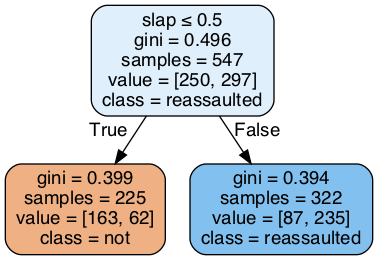

In [47]:
model.plot_decision_tree(clf, features[0:25], ['not', 'reassaulted'])

##  Random Forest:

### A Random Forest model can typically be a high performing model.  We will investigate it here for posterity, though we are unlikely to utilize it in finality or production in this instance.  A sensitive human-based topic such as domestic abuse is highly prone to bias and utilizing a black box methodology such as this would likely be a poor choice.

In [48]:
r_params = {'max_depth': [2, 3, 4]}

In [49]:
for list_item in list_of_feature_lists[4:]:
    clf, y_pred, y_pred_proba = model.random_forest(list_item, X_train, y_train)
    print('--------------------------------------------------------')
    print(f'Model based on top {len(list_item)} features')
    print('Accuracy of Random Forest classifier on training set: {:.2f}'.format(clf.score(X_train[list_item], y_train)))
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    print('--------------------------------------------------------')

grid cv results: 
   max_depth     score
0          2  0.709324
2          4  0.711152
1          3  0.716636
Cross Validation Results: 
[0.70909091 0.68181818 0.75229358 0.70642202 0.75229358]
--------------------------------------------------------
Model based on top 5 features
Accuracy of Random Forest classifier on training set: 0.74
[[177  73]
 [ 70 227]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       250
           1       0.76      0.76      0.76       297

   micro avg       0.74      0.74      0.74       547
   macro avg       0.74      0.74      0.74       547
weighted avg       0.74      0.74      0.74       547

--------------------------------------------------------
grid cv results: 
   max_depth     score
2          4  0.722121
0          2  0.723949
1          3  0.731261
Cross Validation Results: 
[0.70909091 0.7        0.82568807 0.74311927 0.76146789]
--------------------------------------------------------
Mo

grid cv results: 
   max_depth     score
2          4  0.740402
1          3  0.751371
0          2  0.758684
Cross Validation Results: 
[0.71818182 0.72727273 0.7706422  0.75229358 0.77981651]
--------------------------------------------------------
Model based on top 16 features
Accuracy of Random Forest classifier on training set: 0.78
[[182  68]
 [ 51 246]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       250
           1       0.78      0.83      0.81       297

   micro avg       0.78      0.78      0.78       547
   macro avg       0.78      0.78      0.78       547
weighted avg       0.78      0.78      0.78       547

--------------------------------------------------------
grid cv results: 
   max_depth     score
1          3  0.742230
0          2  0.745887
2          4  0.751371
Cross Validation Results: 
[0.73636364 0.71818182 0.76146789 0.72477064 0.77981651]
--------------------------------------------------------
M

grid cv results: 
   max_depth     score
0          2  0.744059
2          4  0.749543
1          3  0.751371
Cross Validation Results: 
[0.74545455 0.69090909 0.78899083 0.75229358 0.74311927]
--------------------------------------------------------
Model based on top 27 features
Accuracy of Random Forest classifier on training set: 0.78
[[185  65]
 [ 58 239]]
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       250
           1       0.79      0.80      0.80       297

   micro avg       0.78      0.78      0.78       547
   macro avg       0.77      0.77      0.77       547
weighted avg       0.77      0.78      0.77       547

--------------------------------------------------------
grid cv results: 
   max_depth     score
0          2  0.738574
1          3  0.744059
2          4  0.747715
Cross Validation Results: 
[0.73636364 0.71818182 0.79816514 0.74311927 0.74311927]
--------------------------------------------------------
M

grid cv results: 
   max_depth     score
0          2  0.749543
1          3  0.755027
2          4  0.755027
Cross Validation Results: 
[0.74545455 0.71818182 0.78899083 0.76146789 0.74311927]
--------------------------------------------------------
Model based on top 38 features
Accuracy of Random Forest classifier on training set: 0.78
[[187  63]
 [ 57 240]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       250
           1       0.79      0.81      0.80       297

   micro avg       0.78      0.78      0.78       547
   macro avg       0.78      0.78      0.78       547
weighted avg       0.78      0.78      0.78       547

--------------------------------------------------------
grid cv results: 
   max_depth     score
0          2  0.749543
1          3  0.755027
2          4  0.755027
Cross Validation Results: 
[0.74545455 0.71818182 0.78899083 0.76146789 0.74311927]
--------------------------------------------------------
M

## Test results of liblinear Logistic Regression model using top 9 features:

In [50]:
clf, y_pred, y_pred_proba = model.log_reg(features[:9], X_train, y_train, solver='liblinear')

Cross Validation Results: 
[0.72727273 0.7        0.79816514 0.75229358 0.77981651]


In [51]:
clf.fit(X_test[features[:9]], y_test)
y_pred = clf.predict(X_test[features[:9]])
y_pred_proba = clf.predict_proba(X_test[features[:9]])
print('Accuracy of logreg classifier on test set: {:.2f}'
     .format(clf.score(X_test[features[:9]], y_test)))

Accuracy of logreg classifier on test set: 0.84


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        44
           1       0.84      0.87      0.85        53

   micro avg       0.84      0.84      0.84        97
   macro avg       0.83      0.83      0.83        97
weighted avg       0.83      0.84      0.83        97

